In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
### and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
### for a year in the data set
print(calc_temps('2017-08-01', '2017-08-07'))

# Set calculations to a list for plotting
temp_stats = list(np.ravel((calc_temps('2017-08-01', '2017-08-07'))))
print(temp_stats)

[(72.0, 79.25, 83.0)]
[72.0, 79.25, 83.0]


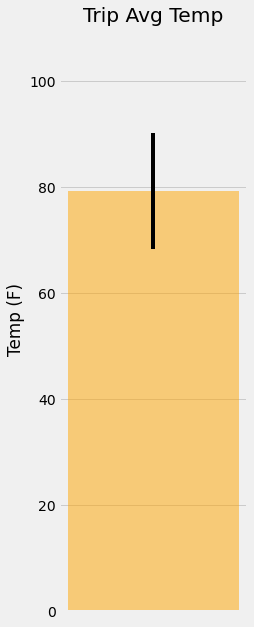

In [27]:
# Plot the results from your previous query as a bar chart. 
### Use "Trip Avg Temp" as your Title
### Use the average temperature for bar height (y value)
### Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
peak_to_peak = (temp_stats[2] - temp_stats[0])
plt.figure(figsize=(3,10))
plt.bar(1, temp_stats[1], yerr=peak_to_peak, color='orange', alpha=.5, ecolor='black')
plt.xticks(np.arange(1,1,step=1))
plt.ylim(0,110)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.show()

### Daily Rainfall Average

In [44]:
# Calculate the total amount of rainfall per weather station for your trip dates,
### using the previous year's matching dates.
# Sort this in descending order by precipitation amount,
### and list the station, name, latitude, longitude, and elevation

# Use inspect to get column names for both tables 
# ---will use as reference for Join 
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
station_columns = inspector.get_columns('station')
for column in measurement_columns:
    print(column['name'], column['type'])
for column in station_columns:
    print(column['name'], column['type'])

# Run query, joining on 'station' columns using filter()
trip_prcp = session.query(func.sum(Measurement.prcp), Measurement.station, Station.name, 
                          Station.latitude, Station.longitude, Station.elevation).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= '2017-08-01').\
    filter(Measurement.date <= '2017-08-07').\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

trip_prcp_df = pd.DataFrame(trip_prcp, columns=['Total PRCP', 'Station ID', 'Station Name',
                                                'Station Lat.', 'Station Long.', 'Station Elevation'])
trip_prcp_df

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


,Total PRCP,Station ID,Station Name,Station Lat.,Station Long.,Station Elevation
0,0.36,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,0.22,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
2,0.06,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
3,0.04,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
4,0.00,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5


### Daily Temperature Normals

In [45]:
# Use this function to calculate the daily normals 
### (i.e. the averages for tmin, tmax, and tavg 
### for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [70]:
# Calculate the daily normals for your trip
# Push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip 
# --- use strptime() to set value types as datetime
start_date = dt.datetime.strptime('2017-08-01', '%Y-%m-%d')
end_date = dt.datetime.strptime('2017-08-07', '%Y-%m-%d')
print(start_date)
print(end_date)

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d 
# --- use strftime() to revert datetime values back to string
trip_dates = []
for i in range(int((end_date-start_date).days)+1):
    trip_dates.append(start_date + dt.timedelta(i))
    trip_dates[i] = trip_dates[i].strftime('%m-%d')
print(trip_dates)

# Use the `daily_normals` function to calculate the normals for each date string 
### and append the results to a list called `normals`.
normals = []
for i in range(len(trip_dates)):
    normals.append(daily_normals(trip_dates[i]))
    normals[i] = list(np.ravel(normals[i]))
print(normals)

2017-08-01 00:00:00
2017-08-07 00:00:00
['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']
[[67.0, 75.54, 83.0], [68.0, 75.60377358490567, 84.0], [70.0, 76.61111111111111, 85.0], [69.0, 76.71153846153847, 84.0], [69.0, 76.14814814814815, 82.0], [67.0, 76.25, 83.0], [71.0, 77.15686274509804, 83.0]]


In [76]:
# Load the previous query results into a Pandas DF, 
### and add the `trip_dates` range as the `date` index

normals_df = pd.DataFrame(normals, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
normals_df['Date'] = trip_dates
normals_df = normals_df.set_index('Date')
normals_df

,Min Temp,Avg Temp,Max Temp
Date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


<Figure size 720x288 with 0 Axes>

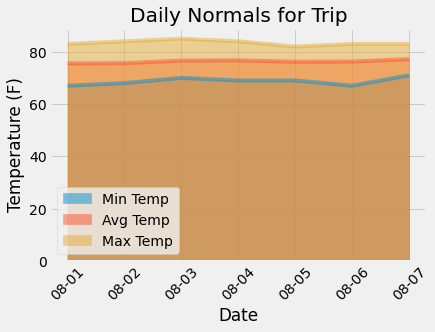

In [84]:
# Plot the daily normals as an area plot with `stacked=False`
plt.figure(figsize=(10,4))
normals_df.plot.area(stacked=False)
plt.xticks(rotation=45)
plt.title('Daily Normals for Trip')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.legend(loc='lower left')
plt.show()

## Close Session

In [83]:
session.close()